### 2-1. 顧客の行動 Pattern の類似度を計算しよう
顧客の行動 Pattern を把握するためには、その行動 Pattern を数値化する必要がある。
数値化できれば、類似度の違いで計算できる。

> #### 類似度
> 似ている度合い

> #### 特徴 Vector
> 評価したい対象を数値化したもの。
> ※類似度も特徴 Vector といえる

#### 機械学習と特徴 Vector の関係
評価したい対象を「特徴 Vector」とする。

| 種類         | 関係                                                                     |
|------------|------------------------------------------------------------------------|
| Clustering | 同じような特徴 Vector を持つものを分類すること                                            |
| 分類         | 特徴 Vector が、すでに何らかの方法で分類がなされているものに対して、その原因を分析し、新たな対象がどの分類になされるかを予測すること |
| 回帰         | 特徴 Vector が時系列であった場合に、その時系列 Pattern の傾向を予測すること                         |

In [1]:
# Data を読み込む
import pandas as pd
df_info = pd.read_csv('accomodation_info.csv', index_col=0, parse_dates=[0])
display(df_info)

,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-01 00:02:21,110034,若松 花子,B,19000
2018-11-01 00:03:10,112804,津田 美加子,D,20000
2018-11-01 00:06:19,110275,吉本 美加子,D,20000
2018-11-01 00:08:41,110169,坂本 直人,B,19000
2018-11-01 00:12:22,111504,青山 零,A,15000
...,...,...,...,...
2020-10-31 23:38:51,110049,吉本 篤司,A,3000
2020-10-31 23:42:12,110127,喜嶋 浩,A,3000
2020-10-31 23:47:24,115464,藤本 明美,D,8000


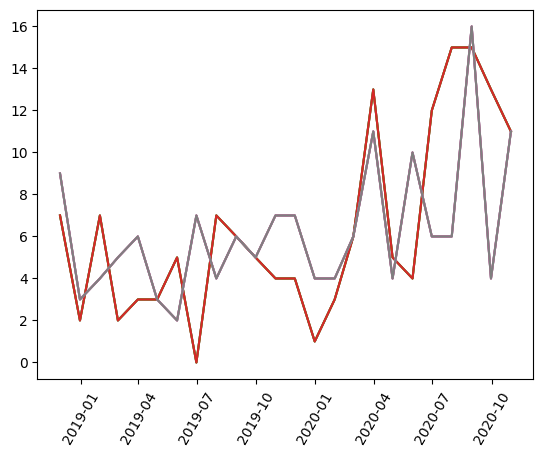

In [2]:
# 特徴 Vector を可視化する
import matplotlib.pyplot as plt

# index の抽出
x_0 = df_info.resample('M').count()
x_0 = x_0.drop(x_0.columns.values, axis=1)

# 順位の設定
i_rank = 1
j_rank = 2
# それぞれの値を変えることで、様々な順位の宿泊者（顧客）の特徴Vector を可視化・類似度計算できる

# 顧客ID の抽出
i_id = df_info['顧客ID'].value_counts().index[i_rank]
j_id = df_info['顧客ID'].value_counts().index[j_rank]

# 月毎の利用回数を特徴量として抽出
# 毎月の利用回数を24次元Vector (24個の数値)とする
x_i = df_info[df_info['顧客ID'] == i_id].resample('M').count()  # 最も利用回数が多い宿泊者
x_j = df_info[df_info['顧客ID'] == j_id].resample('M').count()  # 次に利用回数が多い宿泊者

# 欠損値があった場合の穴埋め
x_i = pd.concat([x_0, x_i], axis=1).fillna(0)
x_j = pd.concat([x_0, x_j], axis=1).fillna(0)

# 描画
# 時系列で重ねて Graph に描画することで、それぞれの特徴Vector がどのようなものであるか把握する
plt.plot(x_i)
plt.plot(x_j)
plt.xticks(rotation=60)
plt.show()

In [3]:
# 類似度を計算する
# 特徴Vector である x_i と x_j との距離を次元数で割ったものを「類似度」と定義する。
import numpy as np

# 特徴Vector の差を計算
dx = x_i.iloc[:, 0].values - x_j.iloc[:, 0].values
# Vector-norm (距離)を計算
n = np.linalg.norm(dx)

# 次元による正規化
num_dim = len(x_i)
d = n / num_dim

print('類似度:', d)  # 0 に近いほど類似性が近いと考える。

類似度: 0.798218502527834


「類似度」は数値が大きいほど類似性が高いとする場合が多いが、計算を簡単にするため「距離」を次元数で割ったものを「類似度」と定義。

> *類似度を計算する方法*
> 相関関係を計算する式である相関係数など様々あり、どのような類似性を計算したいかにより使い分ける。

### 2-2. 類似度と機械学習との関係を知ろう
顧客行動Pattern の分析対象と対応機械学習の種類

| 分析対象                                                 | 機械学習の種類             |
|------------------------------------------------------|---------------------|
| 顧客には、どのような行動Pattern があるか。<br>（どんな Pattern の大口顧客がいるか） | Clustering (教師なし学習) |
| ある顧客が大口顧客になり得るかどうかを予測したい。<br>（あるいは、その原因をしりたい）        | 分類（教師あり学習）          |
| 大口顧客の今後の動向を予測したい。                                    | 回帰（教師あり学習）          |

上記にいたる Process として、まず
1. 特徴Vector の定義（数値化）
2. 多次元の特徴Vector を2次元に**次元削除**

を行ない全体像がわかるように可視化する。

こうして可視化されたいくつかの Sample を
- **「Clustering」** し行動Pattern を分類する。
- 何らかの方法で分類されたその原因を分析したり、その原因から新たな Sample がどの分類がなされるべきかを予測する目的で *「分類」* を行なう。
- 時系列Pattern から今後の動向の予測を **「回帰」**で行なう。

### 2-3. 大口顧客の類似性を主成分分析によって確認しよう
多次元の Vector を二次元の画面に表示するために多次元の中からある２つの次元を軸として選ぶ。
そのため主成分分析を行ない「良い」次元を選定する。

In [4]:
# 特徴 Vector を抽出する
import pandas as pd

# index の調整
x_0 = df_info.resample('M').count()
x_0 = x_0.drop(x_0.columns.values, axis=1)

# 配列を準備
list_vector = []

# 人数の設定
num = 100
for i_rank in range(num):  # 顧客ID の抽出
    i_id = df_info['顧客ID'].value_counts().index[i_rank]  # 月ごとの利用回数を特徴量として抽出
    x_i = df_info[df_info['顧客ID'] == i_id].resample('M').count()  # 欠損値があった場合の穴埋め
    x_i = pd.concat([x_0, x_i], axis=1).fillna(0)  # 特徴Vector として追加
    list_vector.append(x_i.iloc[:, 0].values.tolist())

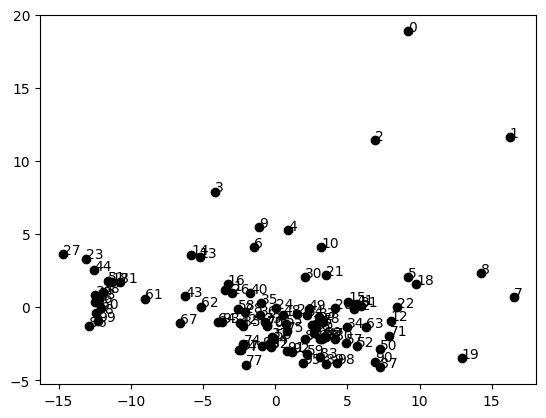

In [5]:
# 主成分分析を行なう
from sklearn.decomposition import PCA
import numpy
import matplotlib.pyplot as plt

features = np.array(list_vector)  # 特徴Vector を変換
# 主成分分析を実施
pca = PCA()
pca.fit(features)
# 特徴Vector を主成分に変換
transformed = pca.fit_transform(features)
# 可視化
for i in range(len(transformed)):
    plt.scatter(transformed[i, 0], transformed[i, 1], color='k')
    plt.text(transformed[i, 0], transformed[i, 1], str(i))
plt.show()

### 2-4. 大口顧客の行動Pattern を時系列によって確かめよう
主成分分析によって可視化した Sample のうち、一部の特徴Vector を可視化し行動Pattern を確認してみる。

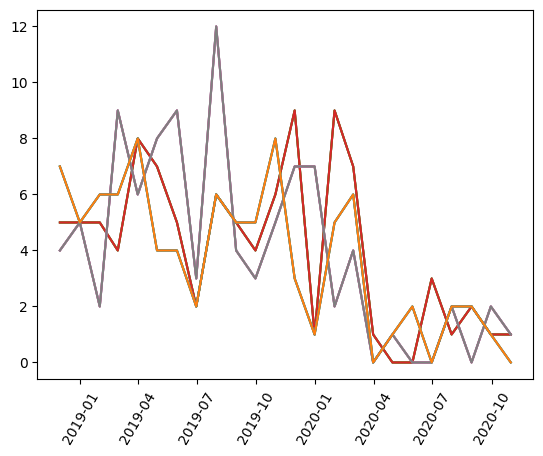

In [6]:
# Sample(顧客) の特徴 Vector を可視化する
import pandas as pd

# index の抽出
x_0 = df_info.resample('M').count()
x_0 = x_0.drop(x_0.columns.values, axis=1)

# 順位の設定
list_rank = [23, 27, 44]
x = []

for i_rank in list_rank:
    i_id = df_info['顧客ID'].value_counts().index[i_rank]  # 顧客ID の抽出
    x_i = df_info[df_info['顧客ID'] == i_id].resample('M').count()  # 月ごとの利用回数を特徴量として抽出
    x_i = pd.concat([x_0, x_i], axis=1).fillna(0)  # 欠損値があった場合の穴埋め
    # 描画
    plt.plot(x_i)
    plt.xticks(rotation=60)
plt.show()

感染症流行前である2020年２月頃までは利用が多かったが、感染症の流行が始まってから極端に利用が下がっていることがわかる。

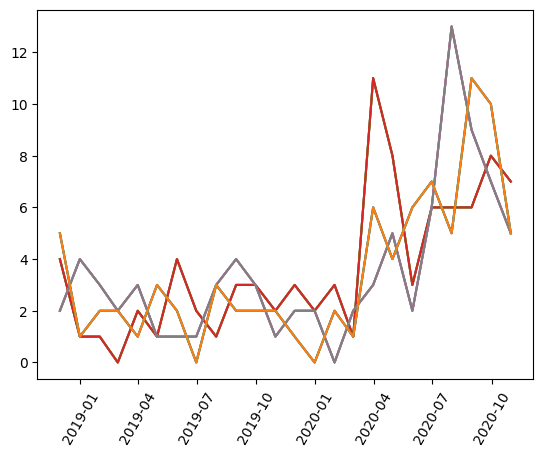

In [7]:
# 順位の設定
list_rank = [50, 63,71]
x = []

for i_rank in list_rank:
    i_id = df_info['顧客ID'].value_counts().index[i_rank]  # 顧客ID の抽出
    x_i = df_info[df_info['顧客ID'] == i_id].resample('M').count()  # 月ごとの利用回数を特徴量として抽出
    x_i = pd.concat([x_0, x_i], axis=1).fillna(0)  # 欠損値があった場合の穴埋め
    # 描画
    plt.plot(x_i)
    plt.xticks(rotation=60)
plt.show()

感染症流行前である2019年ころまではほとんど利用がなかったが、感染症流行の直前あるいはその後に急激に利用が増加している。
比較的新規の大口顧客になっている様子。

### 2-5. 大口顧客同士の行動 Pattern の違いを Clustering によって可視化しよう
k-means法で４つの Cluster に clustering を実施する。

In [8]:
# k-means法による clustering を行なう
from sklearn.cluster import KMeans

num_of_cluster = 4  # Cluster の数を設定

# Cluster に分類
model = KMeans(n_clusters=num_of_cluster, random_state=0)
model.fit(features)
pred_class = model.labels_
print(pred_class)

[3 3 3 1 1 2 1 3 3 1 1 1 2 0 0 2 1 0 2 2 2 2 2 0 1 2 1 0 1 2 1 2 2 2 2 1 1
 1 0 0 1 2 1 0 0 2 0 2 1 2 2 0 2 0 2 1 1 2 1 2 0 0 1 2 1 2 1 0 0 2 1 2 1 1
 1 1 1 1 2 2 2 0 1 2 1 1 0 2 1 2 2 1 1 1 1 1 1 1 2 0]


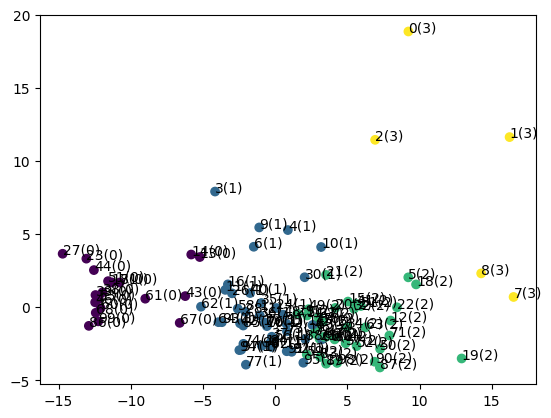

In [9]:
# 主成分分析（PCA）による可視化
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# 主成分分析を実施
pca = PCA()
pca.fit(features)
transformed = pca.fit_transform(features)  # 特徴Vector を主成分に変換

# 可視化
plt.scatter(transformed[:, 0], transformed[:, 1], c=pred_class)
for i in range(len(transformed)):
    text = f"{i}({pred_class[i]})"
    plt.text(transformed[i, 0], transformed[i, 1], text)
plt.show()

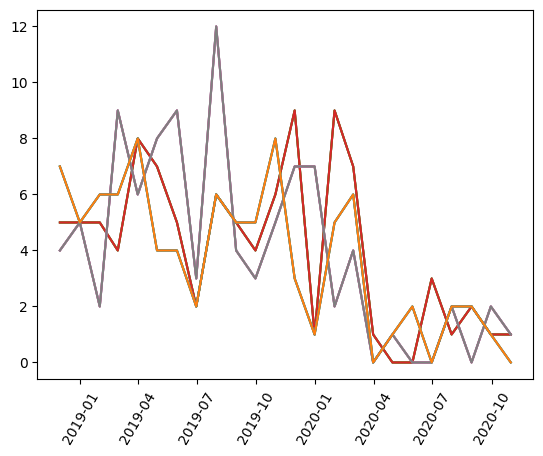

In [10]:
# 紫の Cluster群から Sample を抽出し行動 Pattern を可視化
list_rank = [23, 27, 44]
x = []

for i_rank in list_rank:
    i_id = df_info['顧客ID'].value_counts().index[i_rank]  # 顧客ID の抽出
    x_i = df_info[df_info['顧客ID'] == i_id].resample('M').count()  # 月ごとの利用回数を特徴量として抽出
    x_i = pd.concat([x_0, x_i], axis=1).fillna(0)  # 欠損値があった場合の穴埋め
    # 描画
    plt.plot(x_i)
    plt.xticks(rotation=60)
plt.show()

紫の Clusterは、「感染症流行を経てほぼ利用しなくなってしまった顧客」と考えられる。

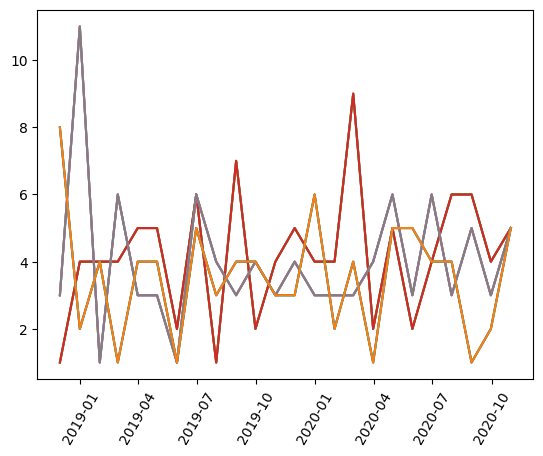

In [11]:
# 青の Cluster群から Sample を抽出し行動 Pattern を可視化
list_rank = [16, 26, 62]
x = []

for i_rank in list_rank:
    i_id = df_info['顧客ID'].value_counts().index[i_rank]  # 顧客ID の抽出
    x_i = df_info[df_info['顧客ID'] == i_id].resample('M').count()  # 月ごとの利用回数を特徴量として抽出
    x_i = pd.concat([x_0, x_i], axis=1).fillna(0)  # 欠損値があった場合の穴埋め
    # 描画
    plt.plot(x_i)
    plt.xticks(rotation=60)
plt.show()

青色の Cluster は、「感染症流行の影響はあまり受けないものの、どちらかというと流行後に利用が減少している傾向にある顧客」と考えられる。

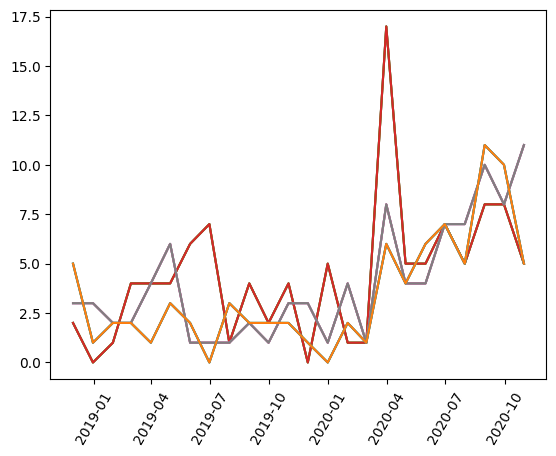

In [12]:
# 緑の Cluster群から Sample を抽出し行動 Pattern を可視化
list_rank = [12, 22, 71]
x = []

for i_rank in list_rank:
    i_id = df_info['顧客ID'].value_counts().index[i_rank]  # 顧客ID の抽出
    x_i = df_info[df_info['顧客ID'] == i_id].resample('M').count()  # 月ごとの利用回数を特徴量として抽出
    x_i = pd.concat([x_0, x_i], axis=1).fillna(0)  # 欠損値があった場合の穴埋め
    # 描画
    plt.plot(x_i)
    plt.xticks(rotation=60)
plt.show()

緑色の Clusterは、「感染症流行前には利用がなかったものの、流行後に利用が急増した顧客」と考えられる。

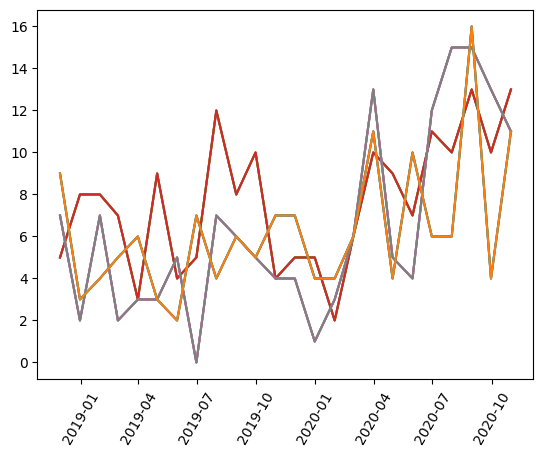

In [13]:
# 緑の Cluster群から Sample を抽出し行動 Pattern を可視化
list_rank = [0, 1, 2]
x = []

for i_rank in list_rank:
    i_id = df_info['顧客ID'].value_counts().index[i_rank]  # 顧客ID の抽出
    x_i = df_info[df_info['顧客ID'] == i_id].resample('M').count()  # 月ごとの利用回数を特徴量として抽出
    x_i = pd.concat([x_0, x_i], axis=1).fillna(0)  # 欠損値があった場合の穴埋め
    # 描画
    plt.plot(x_i)
    plt.xticks(rotation=60)
plt.show()

黄色の Cluster は、「感染症流行前にもある程度の利用はあり、かつ流行後に増加傾向にある顧客」と考えられる。

### 2-6. 決定木によって行動の原因を推定してみよう
前もって分類された Data の Pattern を学習し、未知の Data がどの分類に該当するのかを **「分類Algorithm」** で予測する。
#### 目的
1. 分類された原因・要因を特定する
2. 分類を機械学習によって実現できる精度を確認する（原理的に分類できるのかどうかを確認する）
3. 分類Algorithm によって未知の Data を予測する精度を評価する

| 利用する分類Algorithm | 理由               |
|-----------------|------------------|
| 決定木Algorithm    | 要因を特定することが比較的容易。 |

In [14]:
# 決定木によって行動の原因推定を行なう
import numpy as np

target_class = 2  # 分析したい Class を設定

# 目的変数を作成する
num = len(pred_class)
data_o = np.zeros(num)
for i in range(num):
    if pred_class[i] == target_class:
        data_o[i] = True
    else:
        data_o[i] = False
print(data_o)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0.]


感染症流行後に利用が増えた顧客 Cluster に属する Sample(顧客)を１とし、そうでない Sample(顧客)を０と分類し目的変数とする。

In [15]:
data_e = features  # 説明変数を作成する
print(data_e)

[[ 5.  8.  8. ... 13. 10. 13.]
 [ 7.  2.  7. ... 15. 13. 11.]
 [ 9.  3.  4. ... 16.  4. 11.]
 ...
 [ 6.  6.  3. ...  3.  3.  5.]
 [ 0.  3.  2. ...  8.  6.  4.]
 [ 6.  3.  5. ...  1.  2.  0.]]


目的変数を説明する特徴Vector を説明変数として設定する。


In [16]:
# Model を構築する
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# 決定木の Model 構築を実行する
clf = DecisionTreeClassifier(max_depth=2)
clf = clf.fit(data_e, data_o)

DatetimeIndex(['2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28',
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29',
               '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
               '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31'],
              dtype='datetime64[ns]', name='日時', freq='M')


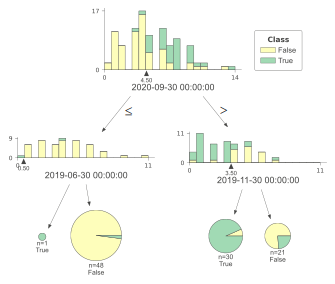

In [17]:
# 決定木を描画する
from dtreeviz.trees import dtreeviz

# index の抽出
x_0 = df_info.resample('M').count()
x_0 = x_0.drop(x_0.columns.values, axis=1)
time_index = x_0.index
print(time_index)

# 決定木を描画
viz = dtreeviz(
    clf,
    data_e,
    data_o,
    target_name='Class',
    feature_names=time_index,
    class_names=['False', 'True']
)
viz

### 2-7. 分類精度を評価しよう

In [18]:
# 混同行列を出力する
from sklearn.metrics import confusion_matrix
pred_tree = clf.predict(data_e)
cm = confusion_matrix(data_o, pred_tree)
print(cm)

[[63  2]
 [ 6 29]]


### 2-8. 予測の精度を評価する流れを理解しよう

In [62]:
# Dataset を訓練Data と TestData に分別する
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, data_o)

In [63]:
# 訓練 Data による Model を構築する
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=2)
clf = clf.fit(x_train, y_train)

In [64]:
# 予測精度評価を行なう
from sklearn.metrics import confusion_matrix

# Score 算出
score = clf.score(x_test, y_test)
print('Score:', score)

# 混同行列生成
pred_tree = clf.predict(x_test)
cm = confusion_matrix(y_test, pred_tree)
print('混同行列')
print(cm)

Score: 0.84
混同行列
[[18  1]
 [ 3  3]]
